In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [18]:
data = pd.read_csv('./diabetes.csv') 

In [19]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [20]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [21]:
# 데이터와 타겟 분리
X = data.drop(['BMI','Outcome'], axis=1).values
y = data['BMI'].values

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [24]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [25]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [27]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1077.3164
Epoch 2, Loss: 1034.7488
Epoch 3, Loss: 974.8081
Epoch 4, Loss: 884.4952
Epoch 5, Loss: 751.0017
Epoch 6, Loss: 591.2841
Epoch 7, Loss: 420.1775
Epoch 8, Loss: 257.1522
Epoch 9, Loss: 156.2548
Epoch 10, Loss: 108.2404
Epoch 11, Loss: 87.1599
Epoch 12, Loss: 79.8770
Epoch 13, Loss: 77.8788
Epoch 14, Loss: 75.7666
Epoch 15, Loss: 69.4412
Epoch 16, Loss: 66.6952
Epoch 17, Loss: 74.5851
Epoch 18, Loss: 66.1378
Epoch 19, Loss: 62.5473
Epoch 20, Loss: 62.3912
Epoch 21, Loss: 61.1384
Epoch 22, Loss: 58.8564
Epoch 23, Loss: 63.9515
Epoch 24, Loss: 56.5411
Epoch 25, Loss: 58.3162
Epoch 26, Loss: 54.7749
Epoch 27, Loss: 52.2448
Epoch 28, Loss: 52.8023
Epoch 29, Loss: 54.8551
Epoch 30, Loss: 50.1928
Epoch 31, Loss: 49.4832
Epoch 32, Loss: 48.6994
Epoch 33, Loss: 49.3380
Epoch 34, Loss: 47.5431
Epoch 35, Loss: 47.6988
Epoch 36, Loss: 47.8670
Epoch 37, Loss: 51.5569
Epoch 38, Loss: 44.6945
Epoch 39, Loss: 45.5761
Epoch 40, Loss: 44.2306
Epoch 41, Loss: 44.1602
Epoch 42, Los

In [30]:
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 51.0193


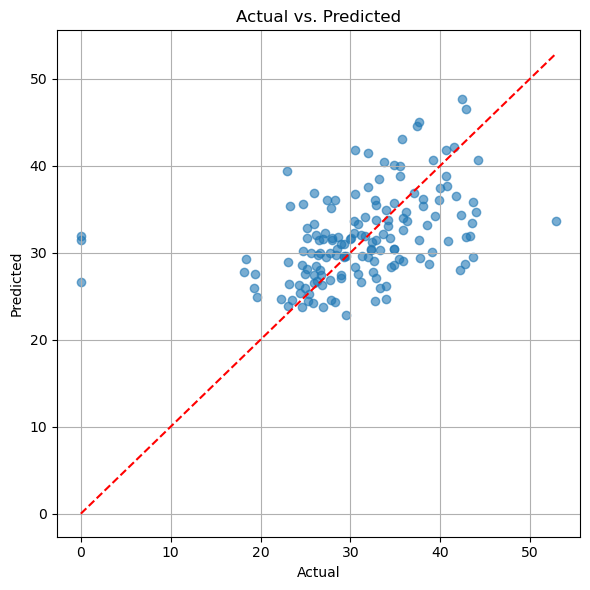

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # 대각선 기준선
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()